In [43]:
from labels import classes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [8]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
df = pd.read_csv('./data/labeled_data.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,text,label,submessage_label
0,Ill send 3 if you send 3 back?,0,17.0
1,perhaps,7,112.0
2,perhaps not,7,118.0
3,Sending 4 back to you this round,0,17.0
4,u and me dawg lets win this thing,0,9.0


In [7]:
sublabel_to_text = {}

for vals in classes.values():
    for sub_message_key, sub_message_val in vals['subclasses'].items():
        sublabel_to_text[sub_message_val] = sub_message_key

In [15]:
# Main classes
x = [text for text in df['text']]
y = [label for label in df['label']]

# Subclasses
for i in range(len(df)):
    text, label = df.loc[df.index[i], ['text', 'submessage_label']]
    x.append(f'{text} [SEP] {sublabel_to_text[label]}')
y += [label for label in df['submessage_label']]

x = np.array(x)
y = np.array(y)

print(x.shape, y.shape)

(1392,) (1392,)


In [34]:
TRAIN_SIZE = 0.8
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=TRAIN_SIZE)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1113,) (1113,) (279,) (279,)


In [35]:
x_train = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=35, return_tensors='tf')
x_test = tokenizer(list(x_test), truncation=True, padding='max_length', max_length=35, return_tensors='tf')

x_train, x_test = x_train['input_ids'], x_test['input_ids']

print(x_train.shape, x_test.shape)

(1113, 35) (279, 35)


In [36]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [41]:
loss = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=3e-5)
model_checkpoint = ModelCheckpoint(f'./finetuned_{model_ckpt}', save_best_only=True, verbose=1)
model.compile(optimizer=optimizer, metrics=SparseCategoricalAccuracy(), loss=loss)

In [42]:
BATCH_SIZE = 32
EPOCHS = 5
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[model_checkpoint])

Epoch 1/5


2024-11-25 10:57:41.079782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-25 10:57:41.645517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


35/35 [==============================] - ETA: 0s - loss: 0.1333 - sparse_categorical_accuracy: 0.1366
Epoch 1: val_loss improved from inf to 0.11885, saving model to ./finetuned_distilbert-base-uncased


INFO:tensorflow:Assets written to: ./finetuned_distilbert-base-uncased/assets


INFO:tensorflow:Assets written to: ./finetuned_distilbert-base-uncased/assets


35/35 [==============================] - 42s 723ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.1366 - val_loss: 0.1189 - val_sparse_categorical_accuracy: 0.1326
Epoch 2/5
35/35 [==============================] - ETA: 0s - loss: 0.1340 - sparse_categorical_accuracy: 0.1303
Epoch 2: val_loss improved from 0.11885 to 0.11785, saving model to ./finetuned_distilbert-base-uncased


INFO:tensorflow:Assets written to: ./finetuned_distilbert-base-uncased/assets


INFO:tensorflow:Assets written to: ./finetuned_distilbert-base-uncased/assets


35/35 [==============================] - 17s 480ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.1303 - val_loss: 0.1179 - val_sparse_categorical_accuracy: 0.1326
Epoch 3/5
35/35 [==============================] - ETA: 0s - loss: 0.1300 - sparse_categorical_accuracy: 0.1258
Epoch 3: val_loss did not improve from 0.11785
35/35 [==============================] - 11s 309ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.1258 - val_loss: 0.1190 - val_sparse_categorical_accuracy: 0.1326
Epoch 4/5
35/35 [==============================] - ETA: 0s - loss: 0.1363 - sparse_categorical_accuracy: 0.1258
Epoch 4: val_loss did not improve from 0.11785
35/35 [==============================] - 11s 307ms/step - loss: 0.1363 - sparse_categorical_accuracy: 0.1258 - val_loss: 0.1201 - val_sparse_categorical_accuracy: 0.1326
Epoch 5/5
35/35 [==============================] - ETA: 0s - loss: 0.1407 - sparse_categorical_accuracy: 0.1177
Epoch 5: val_loss did not improve from 0.11785
35/35 [======

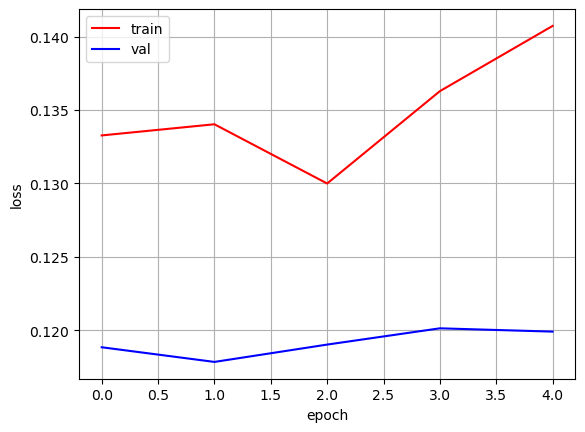

In [44]:
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()